
- 0205에 전처리한 데이터 셋 사용 - p_train ,p_test
- oversampling 시행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import sklearn as sk

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
train      = pd.read_csv("p_train.csv")
test       = pd.read_csv("p_test.csv")

train = train.drop(columns=["Unnamed: 0","index"])
test = test.drop(columns=["Unnamed: 0","index"])

In [4]:
train

,title,topic_idx
0,인천에서핀란드 항공기 결항 휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다 구글 15조원 들여 미국전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근한국기업 특수관계 조명 공과 사 맞물려,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...
45649,KB금융 미국 IB 스티펠과 제휴 선진국 시장 공략,1
45650,서울교육청 신종코로나 확산에 개학 연기 휴업 검토,2
45651,키움증권 2020 키움 영웅전 실전투자대회,1
45652,답변하는 배기동 국립중앙박물관장,2


In [5]:
test

,title
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,어버이날 맑다가 흐려져 남부지방 옅은 황사
2,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...,...
9126,인천 오후 3시35분 대설주의보 눈 3.1CM 쌓여
9127,노래방에서 지인 성추행 외교부 사무관 불구속 입건
9128,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129,아리랑TV 아프리카개발은행 총회 개회식 생중계


# oversampling

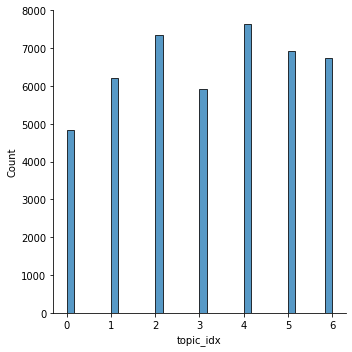

In [6]:
sns.displot(train.topic_idx)

In [7]:
from imblearn.over_sampling import RandomOverSampler

In [8]:
# SMOTE : 오버샘플링
titles_t = train.title.to_numpy().reshape(-1, 1)
labels_t = train.topic_idx.to_numpy().reshape(-1, 1)
oversample = RandomOverSampler()
X_oversample, y_oversample = oversample.fit_resample(titles_t, labels_t)
train = pd.DataFrame({"title": X_oversample.reshape(-1), 'topic_idx': y_oversample.reshape(-1)})

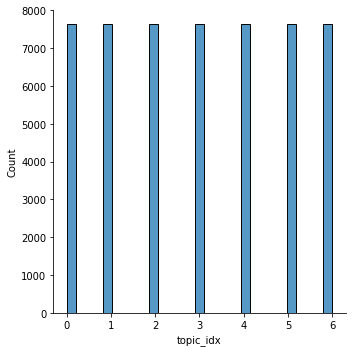

In [9]:
# SMOTE로 클래스별 비율 맞춰준 후 distplot
sns.displot(train.topic_idx)

In [10]:
train.groupby(by=["topic_idx"]).count()

,title
topic_idx,
0,7629
1,7629
2,7629
3,7629
4,7629
5,7629
6,7629


- BERT는 다양한 자연어처리 분야에 적용되어 많은 성능 향상을 보이고 있으며, 대용량 코퍼스를 언어 모델(language model)로 학습한 모델이다.
- 사전 학습 된 BERT 모델에 출력 층(output layer)을 추가한 후에 fine-tuning 하는 방법으로 적용가능
- BERT는 OOV (Out Of Vocabulary) 문제를 해결하기 위하여 BPE (Byte Pair Encoding)를 적용
- BERT는 양방향성을 가진 트랜스포머(transformer)를 기반으로 하며, 각 블록(block)의 셀프 어텐션 매커니즘(self-attention mechanism)으로 문맥 전체를 확인하여 언어 모델을 학습
- 문장 내에서 임의의 단어를 마스킹(masking)하고 이를 예측하는 masked language modeling (masked LM)을 학습
- 주어진 두 문장이 연결된 문장인지 예측하는 다음 문장 예측(next sentence prediction)을 함께 학습

# BERT Fine-tuning
https://velog.io/@jaehyeong/Fine-tuning-Bert-using-Transformers-and-TensorFlow

Bert : 일부 성능평가에서 인간보다 높은 정확도를 보이며 NLP 딥러닝 모델로 주목
- 임베딩 : 사람이 쓰는 자연어를 기계가 이해할 수 있는 형태로 바꾸는 과정

https://happy-obok.tistory.com/23

### 임베딩 관점에서 BERT
- 자연어를 이해하기 위한 양방향 학습 모델을 모두 지원하는 알고리즘
- BERT 사용O : [방대한 코퍼스] -> BERT -> [분류를 원하는 데이터] -> LSTM, CNN 등의 머신러닝 모델 -> 분류 
- 분류를 원하는 데이터 : 모든 단어 벡터들을  참고한 문맥 정보를 가진 벡터
- Base(12)와 Large(24) 버전으로 구분


In [13]:
# 트랜스포머의 인코더를 쌓아 올린 구조 = BERT의 기본 구조
# !pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import torch
from torch.utils.data import Dataset, DataLoader

In [45]:
train_df = train.copy()

In [46]:
### Label Encoding

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_df['topic_idx'])
num_labels = len(label_encoder.classes_)

train_df['encoded_label'] = np.asarray(label_encoder.transform(train_df['topic_idx']), dtype=np.int32)
train_df.head()

,title,topic_idx,encoded_label
0,인천에서핀란드 항공기 결항 휴가철 여행객 분통,4,4
1,실리콘밸리 넘어서겠다 구글 15조원 들여 미국전역 거점화,4,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,4
3,NYT 클린턴 측근한국기업 특수관계 조명 공과 사 맞물려,4,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,4


In [48]:
# 텍스트와 라벨 따로 분리
train_texts = train_df["title"].to_list() # Features (not-tokenized yet)
train_labels = train_df["encoded_label"].to_list() # Labels

In [49]:
# 모델 검증을 위해 분리
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=0)

1. 토큰이 단어 집합에 존재 
- 해당 토큰을 분리하지 않음
2. 토큰이 단어 집합에 존재하지 않음 
- 해당 토큰을 서브워드로 분리   
- 해당 토큰의 첫 번째 서브워드를 제외한 나머지 서브워드들은 앞에                                              '##'를 붙인 것을 토큰으로 함

In [16]:
# HuggingFace의 Transformers라이브러리를 활용
# Transformers를 통해 저장된 모델은 기본적으로 pretrained model, tokenizer, vocab, config 파일 등을 포함하고 있으며, from_pretrained() 메소드를 통해 로드할 수 있다.
from transformers import BertTokenizerFast

# 한국어 BERT 모델인 KLUE-BERT Model Path
HUGGINGFACE_MODEL_PATH = "klue/bert-base"

# Load Tokenizer :: 단어보다 더 작은 단위로 쪼개는 토크나이저
# BertTokenizerFast() 속도는 빠르지만 성능에 영향을 줄 수 있어 다른 방법 선택 가능
# 파라미터 튜닝 참고 : https://huggingface.co/docs/transformers/main_classes/tokenizer
tokenizer = BertTokenizerFast.from_pretrained(HUGGINGFACE_MODEL_PATH)

### Pre-training

In [50]:
# Tokenizing - 데이터 패딩 : 패딩이 아니면 1, 패딩이면 0, 0인 부분은 속도향상
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [52]:
# 토큰화한 데이터 셋을 Tensorflow의 Dataset object로 변환을 위해 from_tensor_slices()메서드를 수행
import tensorflow as tf

## 라벨이랑 텍스트랑 분리해서 인코딩했으니 다시 붙이는 과정인건가?

# trainset-set
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

# validation-set
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [20]:
train_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(27,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(27,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(27,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

### fine-tuning BERT 
tensorflow 적용

In [53]:
# 텍스트 분류를 위해 TFBertForSequenceClassification 활용
from transformers import TFBertForSequenceClassification

# KLUE-BERT 모델을 다운로드 및 로드를 수행
num_labels = len(label_encoder.classes_) # 7
model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=num_labels, from_pt=True) #Tensorflow모델로 변환 및 로드

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
from tensorflow.keras.callbacks import EarlyStopping

# training 사전 종료를 위해 함수 적용
callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

In [62]:
model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=5, batch_size=16,
    validation_data = val_dataset.shuffle(1000).batch(16)
    )

Epoch 1/5


AttributeError: ignored

In [ ]:
train_dataset.shuffle(1000)

<ShuffleDataset element_spec=({'input_ids': TensorSpec(shape=(27,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(27,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(27,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

다른 파인튜닝 방법 : transformers의 TFTrainer

이 방법을 적용하려면 labeling decoding도 다시 확인

In [55]:
from transformers import TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs'            # directory for storing logs
)

with training_args.strategy.scope():
    trainer_model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=num_labels, from_pt=True)

trainer = TFTrainer(
    model=trainer_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
# training
trainer.train()

TypeError: ignored

### saving model

In [57]:
import re

In [58]:
id2labels = model.config.id2label
model.config.id2label = {id : label_encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0]  for id, label in id2labels.items()}

label2ids = model.config.label2id
model.config.label2id = {label_encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0] : id   for id, label in id2labels.items()}

# 다른 코드로 적용
https://dacon.io/competitions/official/235747/codeshare/3047?page=2&dtype=recent

In [28]:
model_checkpoint = "klue/bert-base"
batch_size = 32
task = "nli"
RANDOM_SEED = 17

In [29]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [30]:
dataset = train

In [31]:
dataset_train, dataset_val = train_test_split(dataset,test_size = 0.2,random_state = RANDOM_SEED)

In [32]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_key, label_key, bert_tokenizer):
        
        self.sentences = [ bert_tokenizer(i,truncation=True,return_token_type_ids=False) for i in dataset[sent_key] ]
        
        if not label_key == None:
            self.mode = "train"
        else:
            self.mode = "test"
            
        if self.mode == "train":
            self.labels = [np.int64(i) for i in dataset[label_key]]
        else:
            self.labels = [np.int64(0) for i in dataset[sent_key]]

    def __getitem__(self, i):
        if self.mode == "train":
            self.sentences[i]["label"] = self.labels[i]
            return self.sentences[i]

        else:
            return self.sentences[i]

    def __len__(self):
        return (len(self.labels))

In [33]:
data_train = BERTDataset(dataset_train, "title", "topic_idx", tokenizer)
data_val = BERTDataset(dataset_val, "title", "topic_idx", tokenizer)
data_test = BERTDataset(test, "title", None, tokenizer)

In [34]:
num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [39]:
#!pip install datasets
from datasets import load_metric

metric = load_metric("glue", "qnli")

In [40]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [41]:
metric_name = "accuracy"

args = TrainingArguments(
    "test-nli",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

ValueError: ignored